In [176]:
import pandas as pd
from pandas_datareader import data as pdr
import numpy as np
import datetime as dt
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_style("whitegrid")
import scipy as scs
import scipy.stats as stats
import statistics
from scipy.stats import norm
import math

# Individual stocks

In [126]:
# List the tickers to be retreived
tickers = ['AAPL']

# get close data of the tickers
data = pdr.get_data_yahoo(tickers, start="2000-01-01", end=dt.date.today())['Close']

# return the natural log of daily changes
lnReturns = np.log(data / data.shift(1))[1:]

# Rename column for generic script
lnReturns = lnReturns.rename(columns={lnReturns.columns[0]:'close'})

In [127]:
# Calculate the mean and standard deviations
port_mean = sum(lnReturns['close'])/len(lnReturns['close'])
port_std = np.std(lnReturns['close'])

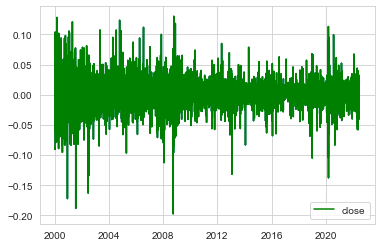

In [177]:
# plot the logged returns to visuallise and identify any outliers
plt.plot(lnReturns)
plt.plot(lnReturns['close'], label='close', color='green')
plt.legend()

In [178]:
# Locating the outlier
lnReturns[lnReturns['close']<-0.6]
          
# Drop an outlier
lnReturns = lnReturns.drop(lnReturns[lnReturns['close']<-0.6].index)

# Check its still there
lnReturns[lnReturns['close']<-0.6]

Symbols,close
Date,


519.2727272727273

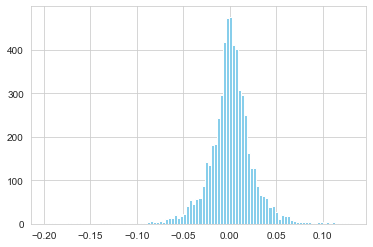

In [179]:
plot = plt.hist(lnReturns['close'], bins = 100, color = "skyblue")
max(plot[0])+(max(plot[0]))/11

Text(-0.1779727635822816, 317.33333333333337, 'Kurtosis: [5.1792]')

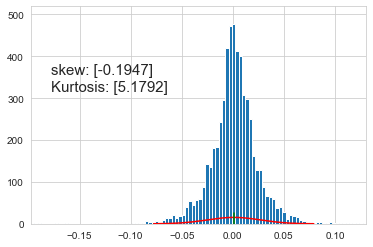

In [180]:
# Visuallising the logged returns distribution
## Histogram
hist = plt.hist(lnReturns['close'],bins=100)

## Generating the normal curve
x = np.linspace(port_mean - 3*port_std, port_mean+3*port_std,1000)

## Plotting the comparable normal curve
plt.plot(x, scs.stats.norm.pdf(x, port_mean, port_std), "r")

## *Adjust the scope*
plt.axis([float(lnReturns.min()), float(lnReturns.max()), 0, max(hist[0])+(max(hist[0]))/11])

## Testing the skew and kurtosis functions
#skew = stats.skew(lnReturns, bias=False)
#kurtosis = stats.kurtosis(lnReturns, bias=False)
#print(' skew: {}'.format(skew),"\n", 'kurtosis: {}'.format(kurtosis))

## Adding a mean line
plt.plot([port_mean,port_mean],[0,25],color="g",label='mean')

## adding skew and kurtosis information to chart // text size and location can be amended but generic ones are attempted
plt.text(float(lnReturns.min())+(0.5*float(lnReturns.min())**2),max(hist[0])-(max(hist[0]))/4,'skew: {}'.format(np.round(stats.skew(lnReturns, bias=False),4)), fontsize=15)
plt.text(float(lnReturns.min())+(0.5*float(lnReturns.min())**2),max(hist[0])-(max(hist[0]))/3,'Kurtosis: {}'.format(np.round(stats.kurtosis(lnReturns, bias=False),4)), fontsize=15)

In [188]:
import numpy as np

def compute_var(x, alpha):
    return -np.percentile(x, alpha*100.0)

def compute_es(x, alpha):
    x_alpha = -compute_var(x, alpha)
    prct = sum(x<=x_alpha)/len(x) 
    y=x*(x<=x_alpha)
    es = -1.0/alpha*(y.mean()+ x_alpha*(alpha-prct))
    return es

print('The simple historical VaR is        {}'.format(compute_var(lnReturns['close'], 0.01)))
print('Corresponding expected shortfall is {}'.format(compute_es(lnReturns['close'], 0.01)))

The simple historical VaR is        0.0659223705449896
Corresponding expected shortfall is 0.08939407235375642


# Portfolio

In [208]:
# List the tickers to be retreived
tickers = ['AAPL','HSBC','C','DIS']

# get close data of the tickers
data = pdr.get_data_yahoo(tickers, start="2000-01-01", end=dt.date.today())['Close']

# return the natural log of daily changes
lnReturns = np.log(data / data.shift(1))[1:]

lnReturns.describe()

Symbols,AAPL,HSBC,C,DIS
count,5655.000000,5655.000000,5655.000000,5655.000000
mean,0.000876,-0.000135,-0.000374,0.000212
std,0.026107,0.017334,0.030319,0.019306
min,-0.731248,-0.208524,-0.494696,-0.202888
25%,-0.010403,-0.007645,-0.010196,-0.008668
50%,0.000886,0.000000,0.000000,0.000272
75%,0.013060,0.007640,0.010067,0.008955
max,0.130194,0.134627,0.456316,0.148180


In [231]:
# As seen in describe, there is no missing values
#lnReturns = lnReturns.dropna()

# Drop that apple outlier again
lnReturns = lnReturns.drop(lnReturns[lnReturns['AAPL']<-0.6].index)

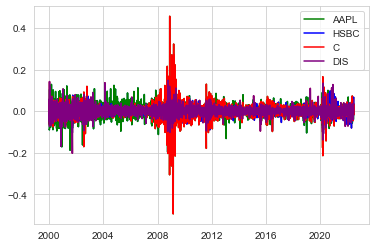

In [232]:
# Visually the logged returns
plt.plot(lnReturns)
plt.plot(lnReturns['AAPL'], label='AAPL', color='green')
plt.plot(lnReturns['HSBC'], label='HSBC', color='blue')
plt.plot(lnReturns['C'], label='C', color='red')
plt.plot(lnReturns['DIS'], label='DIS', color='purple')
plt.legend()

In [233]:
#Create a covariance matrix
cov_matrix = lnReturns.cov()
cov_matrix

Symbols,AAPL,HSBC,C,DIS
Symbols,,,,
AAPL,0.000587,0.000137,0.000242,0.000170
HSBC,0.000137,0.000300,0.000306,0.000157
C,0.000242,0.000306,0.000919,0.000267
DIS,0.000170,0.000157,0.000267,0.000373


In [236]:
from pypfopt.risk_models import CovarianceShrinkage
S = CovarianceShrinkage(data).ledoit_wolf()
S

Symbols,AAPL,HSBC,C,DIS
Symbols,,,,
AAPL,0.159554,0.034216,0.060109,0.042375
HSBC,0.034216,0.076057,0.075343,0.038869
C,0.060109,0.075343,0.231248,0.066216
DIS,0.042375,0.038869,0.066216,0.094968


In [ ]:
weights = np.array([.25, .3, .15, .3])
initial_investment = 1000000
PnL = (weights * lnReturns.values).sum(axis=1)
PnL

In [183]:
historic_var = np.percentile(lnReturns, 1)
print(f'The simple historical VaR is {historic_var}')

The simple historical VaR is -0.0659223705449896
